# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [4]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from sentence_transformers import SentenceTransformer
from shared.utils import experiment, chamfer, load_and_prepare_beir_dataset

# Initialize Params
# ^ can maybe reduce with PCA if we want
n = 100                                 # number of documents
l = 10                                  # trees per forest
k = 10                                  # pivots to keep per node in tree
km = 15                                 # max depth of each tree
a = 10                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)
distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

# Set the dataset name (e.g., "msmarco" or "hotpotqa")
dataset = "hotpotqa"  # NOTE hotpotqa is the wikipedia dataset

# vectors (shape(n, m, pca_dims)), queries (shape(m, pca_dims)) = embedded data
# corpus, query = raw text
# d = length of vectors (768)
# q = length of query (min_q)
vectors, queries, corpus, query, d, q = load_and_prepare_beir_dataset(
    dataset=dataset,
    n=n,           # Number of longest documents
    min_m=200,        # Minimum number of words per document -- will attempt this, don't set too high
    min_q = 15,       # Minimum number of words per query -- will try to find exact match
    pca_dims=25,
    split="test",     # Split type
    save_encoded=True # Save the encoded vectors
)
print(d)

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(best)

def simple_approximate_best(forests: list[LSHForest], queries, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, queries, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


Using model: sentence-transformers/multi-qa-mpnet-base-dot-v1 for dataset: hotpotqa
Looking for raw corpus and query data.
Raw corpus and query data found. Loading from local files.
Selected query with 15 words: "Look At Us Now" is a song by American DJs based in which city ?
Embedding corpus and queries
Converting corpus into list of text
Setting vectors per document (m) to 446
Encoding documents
Encoding the query
Data loading and encoding complete. Found 100 document vectors of shape (100, 446, 25) and query vector of shape (15, 25).
25
(103.80508422851562, 99)


In [5]:
from shared.plotting import plot, plot_similarity_heatmap
from shared.utils import experiment_rec, build_rec_forest, query_rec, recall_rec
import numpy as np
import matplotlib.pyplot as plt

experiments = {
        'l':  list(range(1, 100))
        #'k':  [4, 8, 16, 32, 64],
        #'km': [16, 32, 64, 128, 256],
        #'a':  [1, 4, 8, 16, 32]
}

# Initialize list to store recall scores
recall_scores = []

# Processed vectors as a 2D array (flattened)
processed_vectors = np.concatenate([doc for doc in vectors])

for l in experiments['l']:
    print(f"\nEvaluating Recall@100 with l = {l}")
    #median_ranks, mean_ranks = experiment_rec(var, vals, defaults, processed_vectors, queries, d)
    #print(f"Median ranks for {var} sweep: {median_ranks}")
    #print(f"Mean ranks for {var} sweep: {mean_ranks}")
    
    # Test case 2: Recall test
    forest = build_rec_forest(
        vectors=processed_vectors,
        l=10,  # Using middle value from l sweep
        km=defaults['km'],
        d=d,
        max_split_ratio=5.0,
        max_hash_attempts=10
    )
    
    # Calculate true nearest neighbors here only for the first query from query vector
    query = queries[0] 
    true_dists = np.linalg.norm(processed_vectors - query, axis=1)
    true_nn = np.argsort(true_dists)[:100]  # Top 100 true nearest neighbors
    
    # Get approximate nearest neighbors
    approx_nn = query_rec(forest, query, max_candidates=100, k=100)
    
    # Calculate recall
    recall_score = recall_rec(true_nn, approx_nn, k=100)
    print(f"Recall@100 for l={l}: {recall_score:.2f}")

    # Store recall score for plotting
    recall_scores.append(recall_score)



Evaluating Recall@100 with l = 1
Recall@100 for l=1: 0.26

Evaluating Recall@100 with l = 2
Recall@100 for l=2: 0.21

Evaluating Recall@100 with l = 3
Recall@100 for l=3: 0.25

Evaluating Recall@100 with l = 4
Recall@100 for l=4: 0.28

Evaluating Recall@100 with l = 5
Recall@100 for l=5: 0.38

Evaluating Recall@100 with l = 6
Recall@100 for l=6: 0.23

Evaluating Recall@100 with l = 7
Recall@100 for l=7: 0.32

Evaluating Recall@100 with l = 8
Recall@100 for l=8: 0.23

Evaluating Recall@100 with l = 9
Recall@100 for l=9: 0.26

Evaluating Recall@100 with l = 10
Recall@100 for l=10: 0.33

Evaluating Recall@100 with l = 11
Recall@100 for l=11: 0.23

Evaluating Recall@100 with l = 12
Recall@100 for l=12: 0.26

Evaluating Recall@100 with l = 13
Recall@100 for l=13: 0.26

Evaluating Recall@100 with l = 14
Recall@100 for l=14: 0.22

Evaluating Recall@100 with l = 15
Recall@100 for l=15: 0.20

Evaluating Recall@100 with l = 16
Recall@100 for l=16: 0.26

Evaluating Recall@100 with l = 17
Recall@

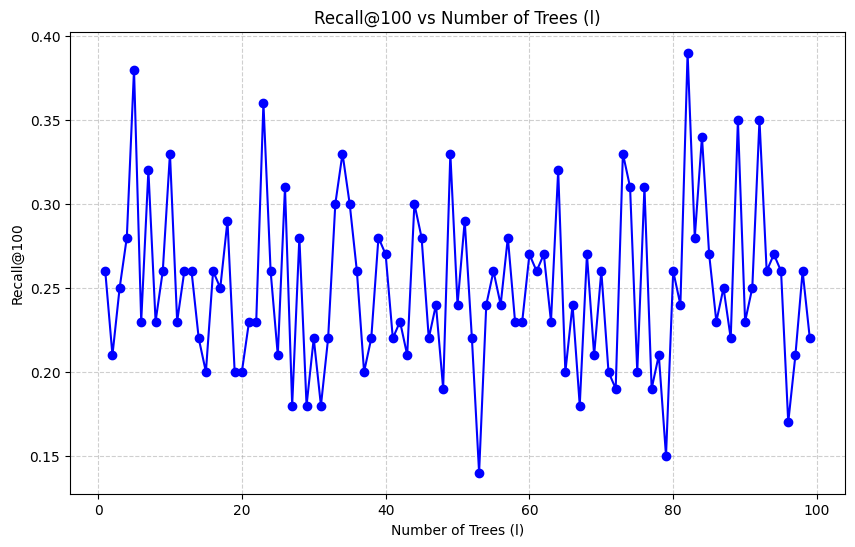

Plot saved as recall_vs_trees_l.pdf


In [6]:
import matplotlib.pyplot as plt

# Plotting Recall@100 vs Number of Trees (l)
plt.figure(figsize=(10, 6))
plt.plot(experiments['l'], recall_scores, marker='o', linestyle='-', color='blue')
plt.title('Recall@100 vs Number of Trees (l)')
plt.xlabel('Number of Trees (l)')
plt.ylabel('Recall@100')
plt.grid(True, linestyle='--', alpha=0.6)
# Save plot as PDF
pdf_filename = "recall_vs_trees_l.pdf"
plt.savefig(pdf_filename, format='pdf')
plt.show()

print(f"Plot saved as {pdf_filename}")
